In [2]:
import keypoint_moseq as kpms
import numpy as np
from jax_moseq.utils import set_mixed_map_iters

In [3]:
MODE = "dannce"   # "dannce" or "sleap"
PROJECT_DIR = "/mnt/d/Project/Keypoint-Moseq/"
KEYPOINT_DATA = "/mnt/d/Project/Keypoint-Moseq/"

Loading keypoints: 100%|██████████████████| 4/4 [00:00<00:00, 21.31it/s]


Fitting model with kappa=10000.0
Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-10000.0


 49%|█████████████████▏                 | 25/51 [00:21<00:23,  1.11it/s]

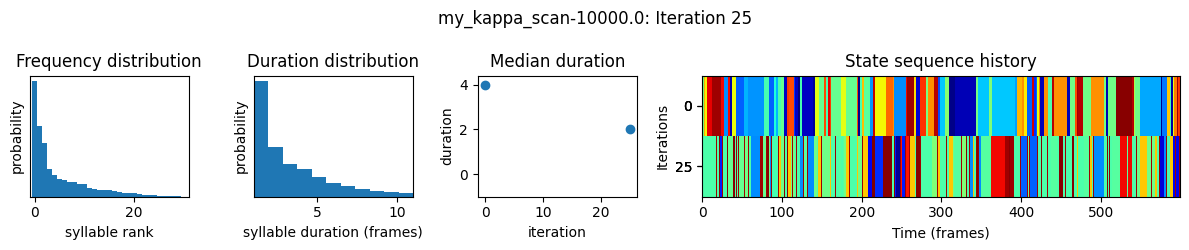

 98%|██████████████████████████████████▎| 50/51 [00:44<00:01,  1.11s/it]

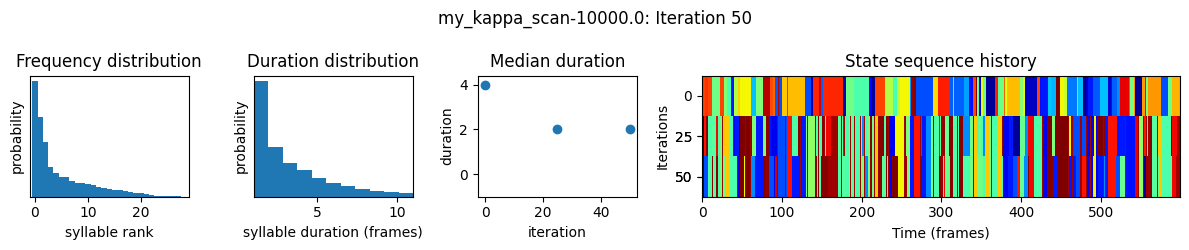

100%|███████████████████████████████████| 51/51 [00:45<00:00,  1.12it/s]


Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-10000.0


 17%|█████▋                            | 25/151 [02:09<10:52,  5.18s/it]

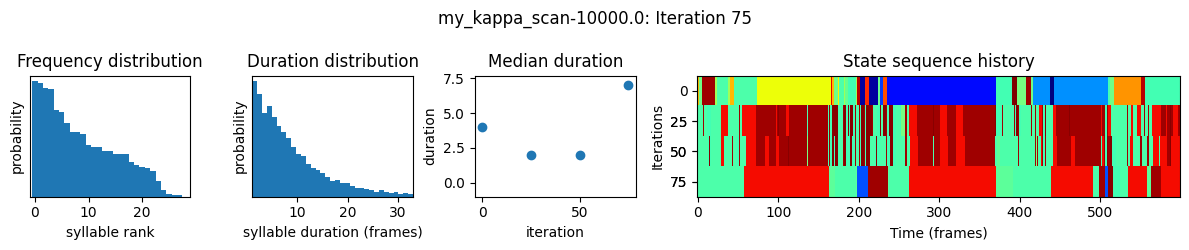

 33%|███████████▎                      | 50/151 [04:17<08:47,  5.23s/it]

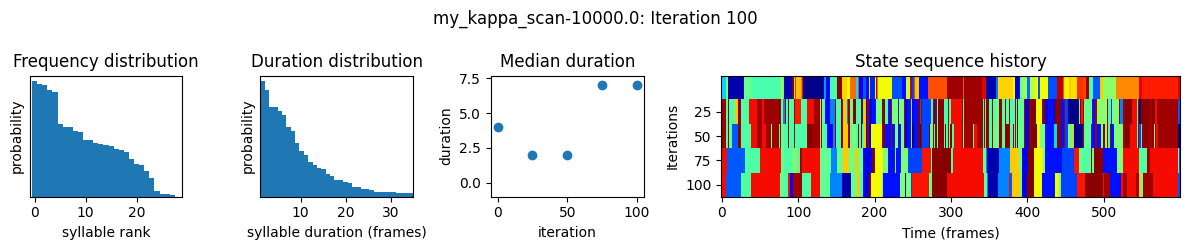

 50%|████████████████▉                 | 75/151 [06:23<06:33,  5.18s/it]

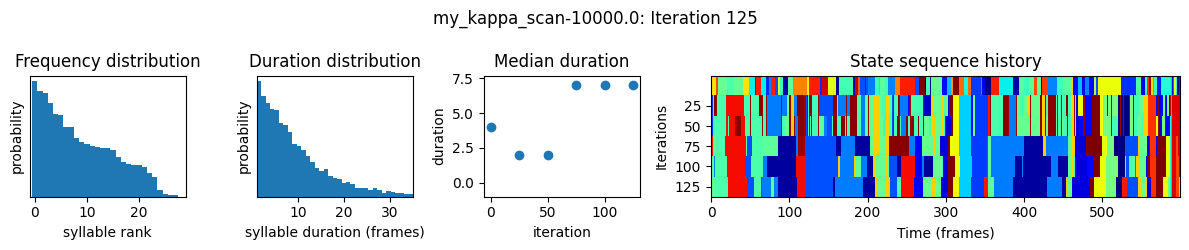

 66%|█████████████████████▊           | 100/151 [08:30<04:06,  4.84s/it]

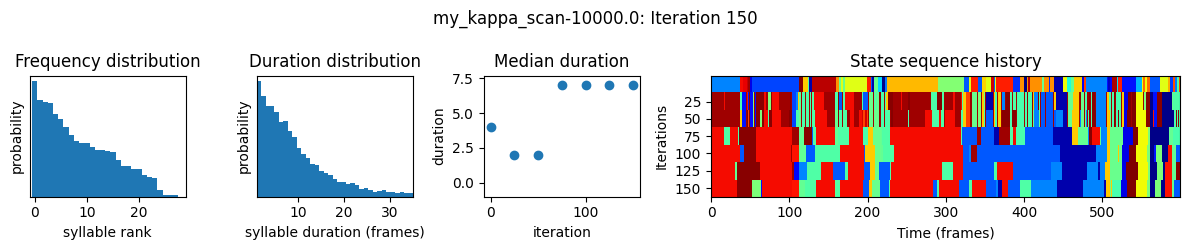

 83%|███████████████████████████▎     | 125/151 [10:39<02:10,  5.01s/it]

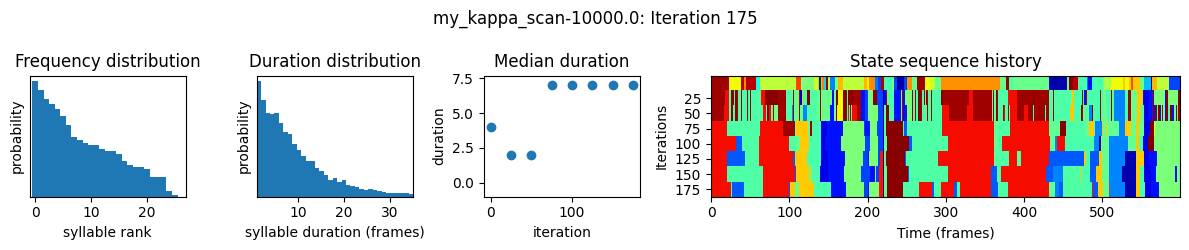

 99%|████████████████████████████████▊| 150/151 [12:48<00:05,  5.23s/it]

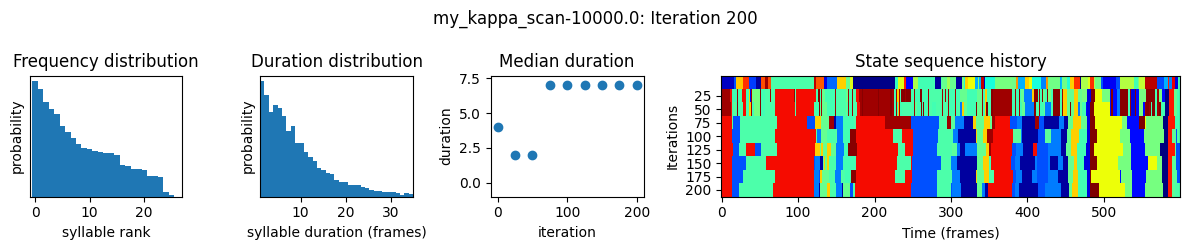

100%|█████████████████████████████████| 151/151 [12:54<00:00,  5.13s/it]


Fitting model with kappa=464158.8833612782
Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-464158.8833612782


 49%|█████████████████▏                 | 25/51 [00:22<00:27,  1.04s/it]

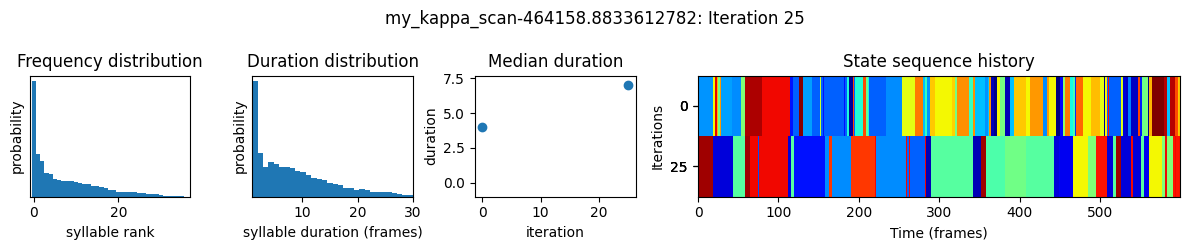

 98%|██████████████████████████████████▎| 50/51 [00:48<00:01,  1.17s/it]

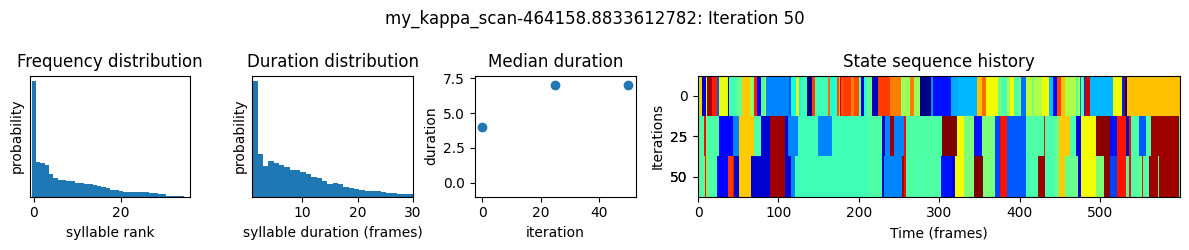

100%|███████████████████████████████████| 51/51 [00:50<00:00,  1.02it/s]


Outputs will be saved to /mnt/d/Project/Keypoint-
Moseq/my_kappa_scan-464158.8833612782


  4%|█▍                                 | 6/151 [00:36<14:53,  6.16s/it]


KeyboardInterrupt: 

In [ ]:
config = lambda: kpms.load_config(project_dir=PROJECT_DIR)
coordinates, confidences, bodyparts = kpms.load_keypoints(filepath_pattern=KEYPOINT_DATA, format=MODE)

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())
pca = kpms.load_pca(project_dir=PROJECT_DIR)

set_mixed_map_iters(4)

kappas = np.logspace(4, 10, 4)
decrease_kappa_factor = 10
num_ar_iters = 50
num_full_iters = 200

prefix = 'my_kappa_scan'

for kappa in kappas:
    print(f"Fitting model with kappa={kappa}")
    model_name = f'{prefix}-{kappa}'
    model = kpms.init_model(data, pca=pca, **config())

    # stage 1: fit the model with AR only
    model = kpms.update_hypparams(model, kappa=kappa)
    model = kpms.fit_model(
        model,
        data,
        metadata,
        PROJECT_DIR,
        model_name,
        ar_only=True,
        num_iters=num_ar_iters,
        save_every_n_iters=25
    )[0]

    # stage 2: fit the full model
    model = kpms.update_hypparams(model, kappa=kappa/decrease_kappa_factor)
    kpms.fit_model(
        model,
        data,
        metadata,
        PROJECT_DIR,
        model_name,
        ar_only=False,
        start_iter=num_ar_iters,
        num_iters=num_full_iters,
        save_every_n_iters=25
    )

kpms.plot_kappa_scan(kappas, PROJECT_DIR, prefix)